# Iris データに対するSelf-Attention

+ L1正則化で，アテンションの値をスパースにする
+ AdamW でパラメータのWeight Decay

Epoch [1/100], Train Loss: 1.2446, Train Accuracy: 32.50%, Test Loss: 1.1435, Test Accuracy: 36.67%
Epoch [2/100], Train Loss: 1.1417, Train Accuracy: 29.17%, Test Loss: 1.1264, Test Accuracy: 13.33%
Epoch [3/100], Train Loss: 1.1192, Train Accuracy: 26.67%, Test Loss: 1.1169, Test Accuracy: 30.00%
Epoch [4/100], Train Loss: 1.1103, Train Accuracy: 32.50%, Test Loss: 1.1106, Test Accuracy: 30.00%
Epoch [5/100], Train Loss: 1.1038, Train Accuracy: 34.17%, Test Loss: 1.1050, Test Accuracy: 30.00%
Epoch [6/100], Train Loss: 1.0999, Train Accuracy: 30.00%, Test Loss: 1.0961, Test Accuracy: 16.67%
Epoch [7/100], Train Loss: 1.0961, Train Accuracy: 15.83%, Test Loss: 1.0918, Test Accuracy: 26.67%
Epoch [8/100], Train Loss: 1.0914, Train Accuracy: 26.67%, Test Loss: 1.0889, Test Accuracy: 10.00%
Epoch [9/100], Train Loss: 1.0894, Train Accuracy: 25.00%, Test Loss: 1.0858, Test Accuracy: 30.00%
Epoch [10/100], Train Loss: 1.0845, Train Accuracy: 31.67%, Test Loss: 1.0818, Test Accuracy: 30.00%

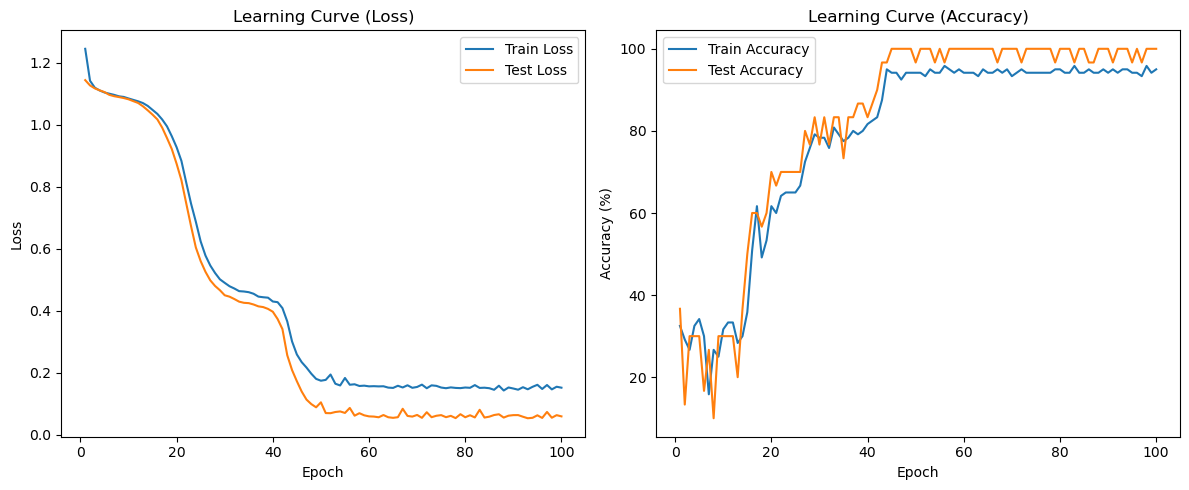

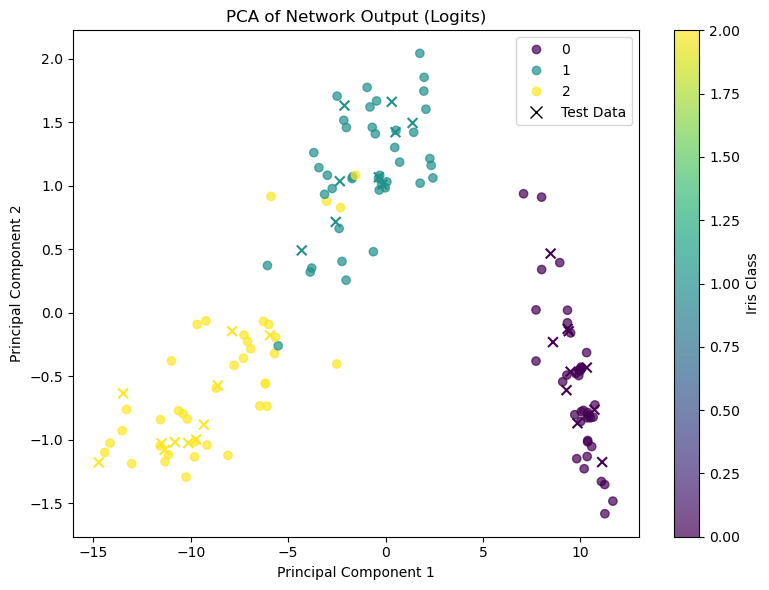

Sample 1 - Attention Weights:
[[1.000 0.000 0.000 0.000]
 [0.844 0.053 0.090 0.012]
 [0.958 0.012 0.028 0.001]
 [0.041 0.226 0.163 0.571]]
Sample 2 - Attention Weights:
[[0.995 0.005 0.000 0.000]
 [0.958 0.041 0.000 0.000]
 [0.108 0.157 0.299 0.436]
 [0.000 0.001 0.079 0.920]]
Sample 3 - Attention Weights:
[[0.999 0.000 0.001 0.000]
 [0.825 0.001 0.174 0.000]
 [0.997 0.000 0.003 0.000]
 [0.390 0.161 0.319 0.129]]
Sample 4 - Attention Weights:
[[1.000 0.000 0.000 0.000]
 [0.944 0.002 0.054 0.000]
 [0.999 0.000 0.001 0.000]
 [0.303 0.227 0.265 0.205]]
Sample 5 - Attention Weights:
[[0.998 0.000 0.002 0.000]
 [0.745 0.071 0.165 0.019]
 [0.958 0.006 0.036 0.000]
 [0.030 0.216 0.107 0.647]]
------------------------------
Mean Attention Weights for Class 0:
[[0.996 0.004 0.000 0.000]
 [0.956 0.040 0.003 0.001]
 [0.150 0.184 0.284 0.382]
 [0.000 0.005 0.116 0.878]]
Mean Attention Weights for Class 1:
[[0.999 0.000 0.001 0.000]
 [0.866 0.022 0.105 0.007]
 [0.989 0.001 0.010 0.000]
 [0.103 0.26

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Irisデータセットのロード
iris = load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)
y = torch.tensor(iris.target, dtype=torch.long)

# データセットの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoaderの作成
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16)

# ニューラルネットワークの定義
class IrisClassifierWithL1Attention(nn.Module):
    def __init__(self, num_tokens, num_classes, num_heads=1, beta=0.001):
        super(IrisClassifierWithL1Attention, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=1, num_heads=num_heads, batch_first=True)
        self.linear = nn.Linear(num_tokens, num_classes)
        self.beta = beta

    def forward(self, x):
        # 入力形状を (batch_size, seq_len, input_dim) に変更
        x = x.unsqueeze(dim=-1)
        attn_output, attn_output_weights = self.self_attn(x, x, x, need_weights=True)
        attn_output = attn_output.squeeze(dim=-1)
        output = self.linear(attn_output)
        return output, attn_output_weights

# モデルのインスタンス化
num_tokens = X_train.shape[1]
num_classes = len(torch.unique(y))
beta = 1.0 # L1正則化の強さを制御するハイパーパラメータ
wd = 0.1 # weight decay
model = IrisClassifierWithL1Attention(num_tokens, num_classes, beta=beta)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=wd)

# 学習曲線を保存するためのリスト
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 学習ループ
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs, attention_weights = model(inputs)
        CEloss = criterion(outputs, labels)

        # Attention Weightに対するL1正則化項を追加 (betaを使用)
        l1_norm = torch.sum(torch.abs(attention_weights))
        loss = CEloss + model.beta * l1_norm

        loss.backward()
        optimizer.step()
        train_loss += CEloss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / train_total
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # 評価
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / test_total
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

print('Training finished.')

# 学習曲線のプロット (変更なし)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve (Accuracy)')
plt.legend()
plt.tight_layout()
plt.show()

# 訓練データのロジットとAttention Weightを取得 (変更なし)
model.eval()
train_logits = []
train_attention_weights = []
train_labels_all = []
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs, attention_weights = model(inputs)
        train_logits.append(outputs.numpy())
        train_attention_weights.append(attention_weights.numpy())
        train_labels_all.append(labels.numpy())
train_logits = np.concatenate(train_logits, axis=0)
train_attention_weights = np.concatenate(train_attention_weights, axis=0)
train_labels_all = np.concatenate(train_labels_all, axis=0)

# テストデータのロジットを取得 (変更なし)
test_logits = []
test_labels_all = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs, _ = model(inputs)
        test_logits.append(outputs.numpy())
        test_labels_all.append(labels.numpy())
test_logits = np.concatenate(test_logits, axis=0)
test_labels_all = np.concatenate(test_labels_all, axis=0)

# PCAによる次元削減 (変更なし)
pca = PCA(n_components=2)
all_logits = np.vstack((train_logits, test_logits))
pca.fit(all_logits)
train_pca = pca.transform(train_logits)
test_pca = pca.transform(test_logits)

# 可視化 (変更なし)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels_all, cmap='viridis', label='Train Data', alpha=0.7)
plt.scatter(test_pca[:, 0], test_pca[:, 1], c=test_labels_all, cmap='viridis', marker='x', s=50, label='Test Data')

# カラーバーと凡例 (変更なし)
cbar = plt.colorbar(scatter)
cbar.set_label('Iris Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Network Output (Logits)')

# クラスごとの凡例を追加 (変更なし)
handles, labels = scatter.legend_elements()
plt.legend(handles + [plt.Line2D([0], [0], marker='x', color='black', linestyle='None', markersize=8, label='Test Data')],
           labels + ['Test Data'])

plt.tight_layout()
plt.show()

# いくつかのサンプルに対するSelf-attentionの計算と表示 (変更なし)
model.eval()
with torch.no_grad():
    # 最初のバッチのデータを取り出す
    data_iter = iter(train_loader)
    sample_inputs, sample_labels = next(data_iter)

    # 最初の5つのサンプルに対してSelf-attentionを計算
    num_samples_to_show = min(5, sample_inputs.shape[0])
    for i in range(num_samples_to_show):
        input_sample = sample_inputs[i].unsqueeze(0)
        input_sample_reshaped = input_sample.unsqueeze(dim=-1)
        _, attention_weights = model.self_attn(input_sample_reshaped, input_sample_reshaped, input_sample_reshaped, need_weights=True)
        print(f"Sample {i+1} - Attention Weights:\n{np.array2string(attention_weights.squeeze().numpy(), formatter={'float_kind': lambda x: '%.3f' % x})}")

    print("-" * 30)

    # 訓練データ中の各クラスのサンプルに対するSelf-attentionの値の平均を計算と表示 (変更なし)
    all_train_attention_weights = []
    all_train_labels = []
    for inputs, labels in train_loader:
        inputs_reshaped = inputs.unsqueeze(dim=-1)
        _, attention_weights = model.self_attn(inputs_reshaped, inputs_reshaped, inputs_reshaped, need_weights=True)
        all_train_attention_weights.append(attention_weights.squeeze().numpy())
        all_train_labels.append(labels.numpy())

    all_train_attention_weights = np.concatenate(all_train_attention_weights, axis=0)
    all_train_labels = np.concatenate(all_train_labels, axis=0)

    mean_attention_per_class = {}
    for class_id in torch.unique(y).numpy():
        class_indices = np.where(all_train_labels == class_id)[0]
        class_attention_weights = all_train_attention_weights[class_indices]
        mean_attention = np.mean(class_attention_weights, axis=0)
        mean_attention_per_class[f"Class {class_id}"] = mean_attention
        print(f"Mean Attention Weights for Class {class_id}:\n{np.array2string(mean_attention, formatter={'float_kind': lambda x: '%.3f' % x})}")

    print("-" * 30)

    # 全結合層の重みをプリント (変更なし)
    for name, param in model.named_parameters():
        if name == 'linear.weight':
            print(f"Linear Layer Weights:\n{param.detach().numpy()}")